In [2]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Modules for generating waveforms
import lalsimulation # Get waveform functions
import lal # Get constants
import pycbc.types # TimeSeries
import pycbc.waveform # Waveforms

# Constants
MPC_SI = 1.0e6 * lal.PC_SI

In [4]:
# Versions of HDF5 earlier than 1.8.13 seem to give trouble
import h5py
print h5py.version.info

Summary of the h5py configuration
---------------------------------

h5py    2.5.0
HDF5    1.8.14
Python  2.7.10 (default, Sep 24 2015, 00:07:46) 
[GCC 4.4.5 20110214 (Red Hat 4.4.5-6)]
sys.platform    linux2
sys.maxsize     9223372036854775807
numpy   1.10.1



In [69]:
sys.path.insert(0, '../src')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb
import timeseriesutils as tsutils

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)
imp.reload(tsutils)

<module 'timeseriesutils' from '../src/timeseriesutils.py'>

# Load ROM

In [6]:
memb_size=2**26-1
Bamp_filename = '../data/Bamp_%d.hdf5'
Bphase_filename = '../data/Bphase_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs.hdf5'
phasecoeff_filename = '../data/phase_coeffs.hdf5'
rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

# Convert to physical units and specify start frequency

In [31]:
def reduced_order_model_physical_units(rom, mass1=None, mass2=None, lambda1=None, lambda2=None, 
                                       delta_t=None, f_lower=None, f_ref=None, 
                                       distance=None, inclination=None, coa_phase=None):
    """
    Construct a waveform with pycbc units from a ROM with dimensionless units. 
    
    Parameters
    ----------
    template: object
        An object that has attached properties. This can be used to subsitute
        for keyword arguments. A common example would be a row in an xml table. 
    approximant : string
        A string that indicates the chosen approximant. See `td_approximants` 
        for available options. 
    mass1 : float
        The mass of the first component object in the binary in solar masses.
    mass2 : 
        The mass of the second component object in the binary in solar masses.
    delta_t :
        The time step used to generate the waveform. 
    f_lower :
        The starting frequency of the waveform.
    f_ref : {float}, optional
        The reference frequency
    distance : {1, float}, optional
        The distance from the observer to the source in megaparsecs.
    inclination : {0, float}, optional
        The inclination angle of the source. 
    coa_phase : {0, float}, optional
        The final phase or phase at the peak of the wavform. See documentation
        on specific approximants for exact usage. 
    lambda1: {0, float}, optional
        The tidal deformability parameter of object 1.
    lambda2: {0, float}, optional
        The tidal deformability parameter of object 2.

    Returns
    -------
    hplus: TimeSeries
        The plus polarization of the waveform.
    hcross: TimeSeries
        The cross polarization of the waveform.
    """
    ################ Checking for correct input ################
    if f_lower < 11.0 or f_lower>700.0: raise ValueError('f_lower must be in range [11, 700]Hz')
    
    if mass1 < 1.0 or mass1 > 2.0 or mass2 < 1.0 or mass2 > 2.0: 
        raise ValueError('Valid mass range: mass1 in [1, 2], mass2 in [1, 2]')
    if lambda1 < 50.0 or lambda1 > 5000.0 or lambda2 < 50.0 or lambda2 > 5000.0: 
        raise ValueError('Valid tidal parameter range: lambda1 in [50, 5000], lambda2 in [50, 5000]')
    
    # Swap (mass1, mass2) and (lambda1, lambda2) if mass1 is not the larger mass
    if mass1 < mass2:
        mass1, mass2 = mass2, mass1
        lambda1, lambda2 = lambda2, lambda1
    
    q = mass2/mass1
    if q > 1.0: raise Exception, 'q must be <= 1.'
    
    #print q, mass1, mass2, lambda1, lambda2
    
    ########## Constructing resampled waveform with physical units #########
    h = rom.evaluate([q, lambda1, lambda2])
    
    # Get times in seconds
    mtot = (mass1+mass2)*lal.MSUN_SI
    time_phys = h.time*lal.G_SI*mtot/lal.C_SI**3
    #print time_phys[0], time_phys[-1]
    
    order = 3
    ampoft = scipy.interpolate.UnivariateSpline(time_phys, h.amp, k=order, s=0)
    phaseoft = scipy.interpolate.UnivariateSpline(time_phys, h.phase, k=order, s=0)
    omegaoft = phaseoft.derivative(n=1)
    freq = omegaoft(time_phys)/(2*np.pi)
    #print freq[0], freq[-1]
    
    #fig = plt.figure(figsize=(12, 4))
    #axes = fig.add_subplot(111)
    #axes.plot(time_phys, freq)
    #axes.set_xscale('symlog', linthreshx=0.001)
    #axes.set_xlabel(r'$t$ (s)', fontsize=16)
    #axes.set_ylabel(r'$f$ (Hz)', fontsize=16)
    
    # Find region where frequency is monotonically increasing, then construct t(f)
    i_end_mono = next( (i for i in range(len(freq)-1) if freq[i]>=freq[i+1]), (len(freq)-1) )
    toffreq = scipy.interpolate.UnivariateSpline(freq[:i_end_mono], time_phys[:i_end_mono], k=order, s=0)
    
    # Resample with even spacing
    tstart = toffreq([f_lower])[0]
    time_phys_res = np.arange(tstart, time_phys[-1], delta_t)
    #print tstart
    #print time_phys_res[0], time_phys_res[-1]
    amp_res = ampoft(time_phys_res)
    phase_res = phaseoft(time_phys_res)
    
    ## Set start time to be 0
    #time_phys_res -= time_phys_res[0]
    
    # Rescale amplitude
    h22_to_h = np.sqrt(5.0/np.pi)/8.0
    amp_units = lal.G_SI*mtot/(lal.C_SI**2*distance*MPC_SI)
    amp_rescale = amp_units*h22_to_h*amp_res
    
    #hresamp = tdwave.TimeDomainWaveform(time_phys_res, amp_rescale, phase_res)
    #return hresamp
    
    inc_plus = (1.0+np.cos(inclination)**2)/2.0
    inc_cross = np.cos(inclination)
    hplus = pycbc.types.TimeSeries(inc_plus*amp_rescale*np.cos(phase_res), 
                                   epoch=tstart, delta_t=delta_t)
    hcross = pycbc.types.TimeSeries(inc_cross*amp_rescale*np.sin(phase_res), 
                                    epoch=tstart, delta_t=delta_t)
    return hplus, hcross

# Test ROM with physical units

In [32]:
# distance, inclination, f_lower, delta_t = 100.0, np.pi/2.0, 11.0, 1.0/2**12
# mass1, mass2, lambda1, lambda2 = 1.0, 1.0, 50.0, 50.0
# hp1, hc1 = reduced_order_model_physical_units(rom, mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
#                                         delta_t=delta_t, f_lower=f_lower, f_ref=None, 
#                                         distance=distance, inclination=inclination, coa_phase=None)
# h1 = tsutils.amp_phase_from_polarizations(hp1, hc1, remove_start_phase=True)

In [74]:
#distance, inclination, f_lower, delta_t = 100.0, 1.1*np.pi/2.0, 100.0, 1.0/2**14
distance, inclination, f_lower, delta_t = 100.0, 0.0, 50.0, 1.0/2**14

mass1, mass2, lambda1, lambda2 = 1.4, 1.4, 50.0, 50.0
hp1, hc1 = reduced_order_model_physical_units(rom, mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                                        delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                                        distance=distance, inclination=inclination, coa_phase=None)

mass1, mass2, lambda1, lambda2 = 1.4, 1.4, 1000.0, 1000.0
hp2, hc2 = reduced_order_model_physical_units(rom, mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                                        delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                                        distance=distance, inclination=inclination, coa_phase=None)

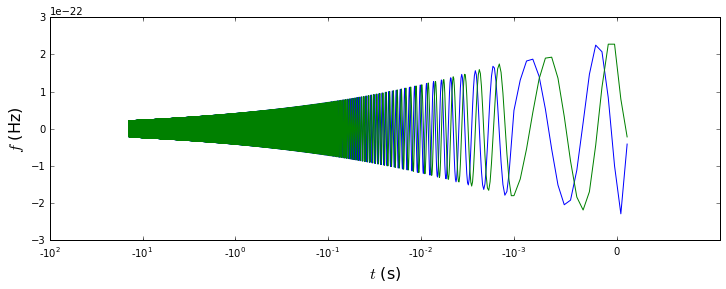

In [75]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(111)
axes.plot(hp1.sample_times, hp1.numpy())
axes.plot(hc1.sample_times, hc1.numpy())
axes.set_xscale('symlog', linthreshx=0.001)
axes.set_xlabel(r'$t$ (s)', fontsize=16)
axes.set_ylabel(r'$f$ (Hz)', fontsize=16)

# Compare ROM to TaylorT4

In [76]:
#distance, inclination, f_lower, delta_t = 100.0, 1.1*np.pi/2.0, 100.0, 1.0/2**14
distance, inclination, f_lower, delta_t = 100.0, 0.0, 50.0, 1.0/2**14

mass1, mass2, lambda1, lambda2 = 1.4, 1.4, 50.0, 50.0
hp1T4, hc1T4 = pycbc.waveform.get_td_waveform(approximant='TaylorT4', mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                                          distance=distance, inclination=inclination, delta_t=delta_t, f_lower=f_lower, f_ref=1000,
                                          phase_order=7, tidal_order=12, amplitude_order=6)

mass1, mass2, lambda1, lambda2 = 1.4, 1.4, 1000.0, 1000.0
hp2T4, hc2T4 = pycbc.waveform.get_td_waveform(approximant='TaylorT4', mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                                          distance=distance, inclination=inclination, delta_t=delta_t, f_lower=f_lower, f_ref=1000,
                                          phase_order=7, tidal_order=12, amplitude_order=6)

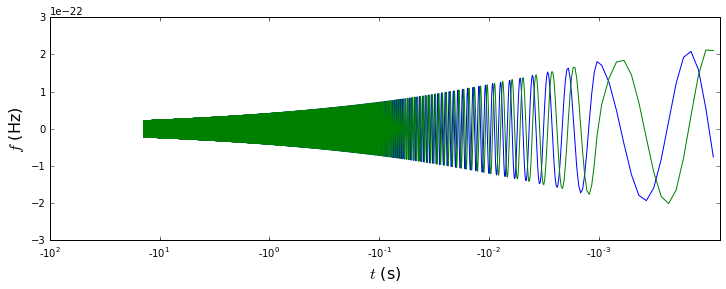

In [77]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(111)
axes.plot(hp1T4.sample_times, hp1T4.numpy())
axes.plot(hc1T4.sample_times, hc1T4.numpy())
axes.set_xscale('symlog', linthreshx=0.001)
axes.set_xlabel(r'$t$ (s)', fontsize=16)
axes.set_ylabel(r'$f$ (Hz)', fontsize=16)

In [79]:
# h_tstart = hp1.sample_times[0]
# hT4_tstart = hp1T4.sample_times[0]

# fig = plt.figure(figsize=(12, 4))
# axes = fig.add_subplot(111)
# axes.plot(hp1.sample_times-h_tstart, hp1.numpy())
# axes.plot(hp1T4.sample_times-hT4_tstart, hp1T4.numpy())
# #axes.set_xscale('symlog', linthreshx=0.001)
# axes.set_xlim([2.0, 2.2])
# axes.set_xlabel(r'$t$ (s)', fontsize=16)
# axes.set_ylabel(r'$f$ (Hz)', fontsize=16)

In [80]:
h1 = tsutils.polarizations_to_complex(hp1, hc1)
h1.start_time-=h1.start_time
h1T4 = tsutils.polarizations_to_complex(hp1T4, hc1T4)
h1T4.start_time-=h1T4.start_time

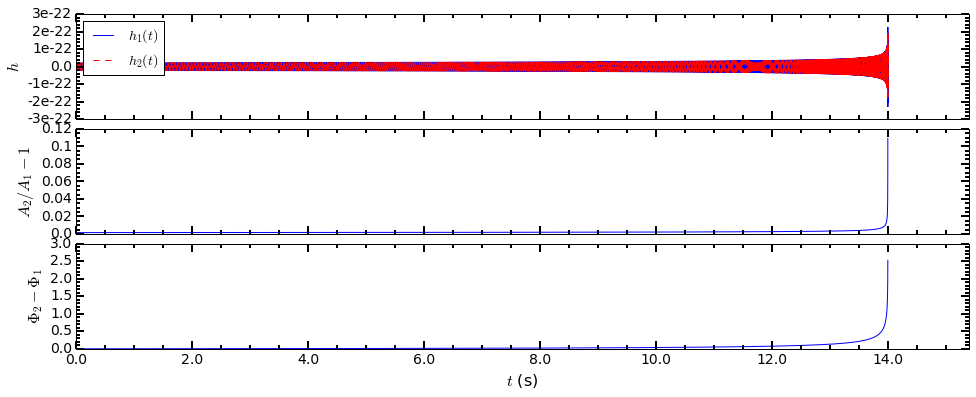

In [82]:
tsutils.compare_two_waveforms(h1, h1T4, mag=None, length=None,
                              remove_start_phase=True,
                              xlabel=r'$t$ (s)', ylabel_wave=r'$h$',
                              ylabel_amp=r'$A_2/A_1 - 1$',
                              ylabel_phase=r'$\Phi_2 - \Phi_1$',
                              labels=[r'$h_1(t)$', r'$h_2(t)$'])